# Analyzing Car Complaints with Watson NLP

Disclaimer: This notebook is intended to be used with an environment based on software configuration _Runtime 23.1 on Python 3.10_.

This notebook demonstrates how to analyze car complaints using Watson NLP.

The data that is used in this notebook is taken from the National Highway and Transit Association (NHTSA) of the US Department of Transportation. The NHTSA records complaints from car owners, and makes them available regularly.  

## What you'll learn in this notebook

Watson NLP offers _blocks_ for various NLP tasks. This notebooks shows:

- **Syntax analysis** with _Syntax block_ for English (`syntax_izumo_en_stock`). This block extracts nouns and their _lemma_ (base form) from the car complaints. This way, for the nouns _wheels_ and _wheel_, the block collects _wheel_. The most frequently used noun lemmas are typical problems that review authors talk about.
- **Noun phrase extraction** with _Noun Phrases block_ for English (`noun-phrases_rbr_en_stock`). This block extracts larger noun phrases from car complaints to yield additional insights. 
- **How to correlate structured data with the analysis results**, with _association rule mining_ . This is used to find the most significant nouns for a particular car model. 


## Table of Contents

1. [Load the car complaints](#loadData)
1. [Analyze complaint descriptions with Watson NLP](#analyzeComplaints)
1. [Explore and analyze the results](#exploreResults)
1. [Identify nouns and noun phrases that are _specific_ to a given Model with Association Rule Mining](#correlate_n_nph)
1. [Summary](#summary)

Begin by importing the Watson NLP library that is used throughout the notebook.

In [1]:
import watson_nlp

<a id="loadData"></a>
## Load the car complaints

The data set used in this notebook from the National Highway and Transit Association (NHTSA) contains complaint records from car owners. The data sample provides information about the make and model of the car, the trouble-causing component, and a brief description of the issue. It also records the company's response to the issue described by the customer, as well as the customer's overall satisfaction level. The data set contains a total of 32 columns and 558 rows.

Load the car complaints into a dataframe.

In [26]:
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

# The raw data doesn't include the column headers. The headers are described at https://static.nhtsa.gov/odi/ffdd/cmpl/CMPL.txt
import_df = pd.read_csv('https://static.nhtsa.gov/odi/ffdd/cmpl/COMPLAINTS_RECEIVED_2020-2023.zip', sep='\t', header=None)
import_df.rename(columns={15: 'Date'}, inplace=True)

# we will only use a subset of the columns in our analysis, and only complaints from 2020-2022
complaint_df = import_df.query('Date < 20220301')[[0,3,4,11,19]]
complaint_df.rename(columns={0: 'Complaint_ID', 3: 'Make', 4: 'Model', 11: 'Component', 19: 'Description'}, inplace=True)
complaint_df.fillna({'Description' : ''}, inplace=True)  # to ensure all descriptions are proper strings for later analysis
complaint_df.astype({'Description': 'str'}, copy=False)


complaint_df.head()

,Complaint_ID,Make,Model,Component,Description
0,1633299,HONDA,ACCORD,SERVICE BRAKES,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN FROM 70MPH TO 40-50MPH,THERE WERE ANY CAR IN FRONT OF ME! I HAVE NOTHING ON MY WINDSHIELD! THERE WEREN'T ANY STOP OR TRAFFIC SIGN! SO HONDA STOP SAYING I AM DRIVING RECKLESSLY! FOR FEW SECOND I REGAINED CONTROL OF GAS, I HAVE TO SPEED UP MY CAR SO I DON'T GET REAR END, THEN EVERYTHING HAPPEN AGAIN, CAR DECIDED TO TAP BRAKE BY ITSELF. THIS HAPPEN ..."
1,1633300,HONDA,ACCORD,ELECTRICAL SYSTEM,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN FROM 70MPH TO 40-50MPH,THERE WERE ANY CAR IN FRONT OF ME! I HAVE NOTHING ON MY WINDSHIELD! THERE WEREN'T ANY STOP OR TRAFFIC SIGN! SO HONDA STOP SAYING I AM DRIVING RECKLESSLY! FOR FEW SECOND I REGAINED CONTROL OF GAS, I HAVE TO SPEED UP MY CAR SO I DON'T GET REAR END, THEN EVERYTHING HAPPEN AGAIN, CAR DECIDED TO TAP BRAKE BY ITSELF. THIS HAPPEN ..."
2,1633301,HONDA,ACCORD,ENGINE,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN FROM 70MPH TO 40-50MPH,THERE WERE ANY CAR IN FRONT OF ME! I HAVE NOTHING ON MY WINDSHIELD! THERE WEREN'T ANY STOP OR TRAFFIC SIGN! SO HONDA STOP SAYING I AM DRIVING RECKLESSLY! FOR FEW SECOND I REGAINED CONTROL OF GAS, I HAVE TO SPEED UP MY CAR SO I DON'T GET REAR END, THEN EVERYTHING HAPPEN AGAIN, CAR DECIDED TO TAP BRAKE BY ITSELF. THIS HAPPEN ..."
3,1633302,FORD,EXPLORER,ELECTRICAL SYSTEM,DEEP SLEEP MODE ACTIVATES AFTER 2 DAYS. MOST RECENT EXPERIENCE INVOLVED HAVING TO JUMP START THE CAR AFTER SETTING 3 DAYS.
4,1633303,CHEVROLET,VOLT,SERVICE BRAKES,"WHILE DRIVING ON CITY STREETS AND HIGHWAYS, THE ADAPTIVE CRUISE CONTROL WILL NOT ENGAGE 25% OF THE TIME AND WILL DISENGAGE WITHOUT NOTICE. ""ADAPTIVE CRUISE CONTROL WILL APPEAR IN DIC. HOWEVER, THIS CREATES A SAFETY HAZARD AS YOU NEVER KNOW IF THE CAR WILL AUTOMATICALLY SLOW DOWN. I HAVE FILED CASE # 9-5379585813 WITH CHEVROLET AND BEEN TO FOUR DEALERS AND THEY REFUSE TO FIX THE PROBLEM. TH..."


### Display the most frequent car makes, models, and component descriptions as bar charts

Try to gain insights from the data by plotting the most frequent car makes, models, and component descriptions as horizontal bar charts.

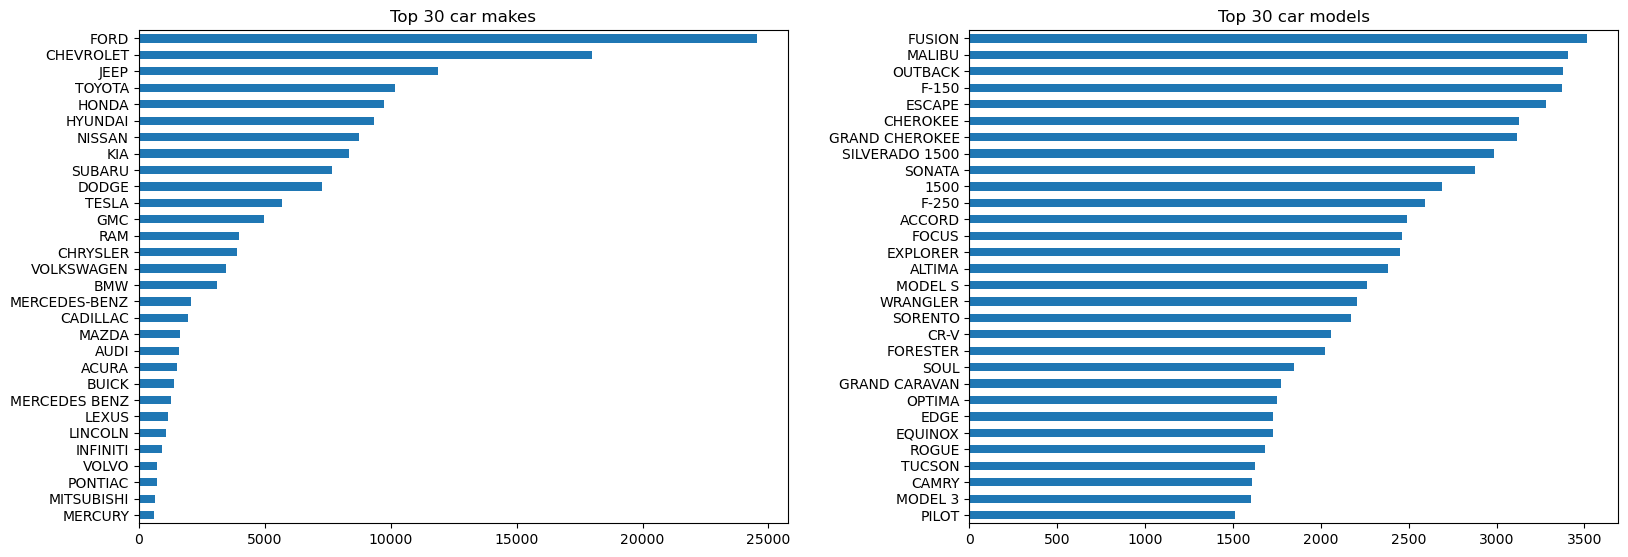

In [27]:
import matplotlib.pyplot as plt

figure, ((ax1, ax2)) = plt.subplots(ncols=2, figsize=(18,8))
figure.tight_layout(pad=10)
complaint_df['Make'].value_counts().head(30).sort_values().plot(kind='barh', ax=ax1) 
ax1.title.set_text('Top 30 car makes')
complaint_df['Model'].value_counts().head(30).sort_values().plot(kind='barh', ax=ax2) 
ax2.title.set_text('Top 30 car models')
plt.show()

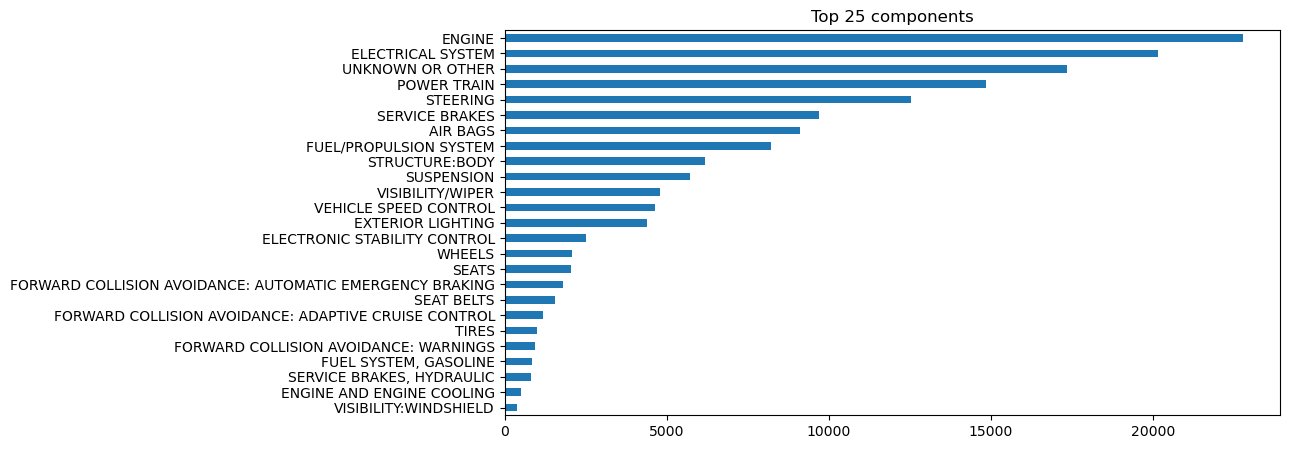

In [28]:
figure, (ax1) = plt.subplots(ncols=1, figsize=(10,5))
complaint_df['Component'].value_counts().head(25).sort_values().plot(kind='barh', ax=ax1) 
ax1.title.set_text('Top 25 components')
plt.show()

While the component classification provides _some_ insights, a large number of complaints use relatively non-descriptive categories like _"engine", "electrical system"_, or _"unknown or other"_. In the remainder of this notebook, you will extract additional insights from the actual complain _descriptions_ with Watson NLP.

<a id="analyzeComplaints"></a>
## Analyze complaint descriptions with Watson NLP

Now that you have looked at the sample data, start extracting additional insights from the data using Watson NLP.

### Loading the syntax and the noun phrase model

What are the typical problems that car owners face with their cars? Using syntax analysis, you can extract nouns from the description of the car complaints. The most frequently used nouns are typical problems that car owners talk about. To gain additional insights, you will use noun phrase extraction to extract larger noun phrases from the car complaints.

Load the `syntax_izumo_en_stock` syntax model and `noun-phrases_rbr_en_stock` noun phrase extraction model for English:

In [22]:
syntax_model = watson_nlp.load('syntax_izumo_en_stock')
noun_phrases_model = watson_nlp.load('noun-phrases_rbr_en_stock')

### Helper methods to extract nouns and noun phrases 

In addition to identifying the nouns present in the car complaints, the syntax model also extracts the _lemma_ (base form) of each noun, instead of the surface form presented in the text. This way, both _wheels_ and _wheel_ are collected as _wheel_.
Watson NLP contains a default set of stopwords that can be used. For this analysis, we define some _specific_ stopwords for this data set to avoid that theyclutter the quantitative analysis later on. 

In [29]:
stopwords = set(['FAILURE', 'VEHICLE', 'VEHICLES', 'PROBLEM', 'CAR', 'FORD', 'MANUFACTURER', 
                 'DEALER', 'CONSUMER', 'DRIVER', 'TIME', 'TIMES', 'ISSUE', 'RECALL'])

def extract_nouns(text):
    syntax_result = syntax_model.run(text, parsers=('lemma', 'part_of_speech'))
    # gather tokens that are nouns and have more than two characters (to avoid picking up some "control words" in the data)
    # collect the lemma instead of the surface form. This way, both "wheels" and "wheel" are collected as "wheel"
    nouns = [token['lemma'] for token in syntax_result.to_dict()['tokens'] if (
        (token['part_of_speech'] == 'POS_PROPN' or token['part_of_speech'] == 'POS_NOUN') and len(token['lemma']) > 2)] 
    # remove stopwords
    nouns = [noun for noun in nouns if noun.upper() not in stopwords]
    return list(set(nouns))  #if a noun occurs several times, we only want to pick it up once

def extract_nps(text):
    np_res = noun_phrases_model.run(text)
    # gather phrases that have more than two characters (to avoid picking up some "control words" in the data), and aren't one of the stopwords
    phrases = [phrase.span.text.lower() for phrase in np_res.noun_phrases if phrase.span.text.upper() not in stopwords and len(phrase.span.text) > 2]
    return list(set(phrases))

from tqdm.notebook import tqdm
tqdm.pandas(colour='green')

# Returns a dataframe that contains Complaint_ID, Model and the Nouns found in the complaint description
# For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. 
# You can also use `apply` from `pandas` directly, i.e. `modelDF['Description'].apply(..)`
def createNounDF(modelDF):
    # extract nouns 
    keywords = modelDF['Description'].progress_apply(lambda x: extract_nouns(x))
    keywordDF = pd.DataFrame(keywords)
    keywordDF.rename(inplace=True, columns={'Description':'Nouns'})
    return modelDF[['Complaint_ID', 'Model']].merge(keywordDF, how='left', left_index=True, right_index=True)

# Returns a dataframe that contains Complaint_ID, Model and the Noun Phrases found in the complaint description
# For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. 
# You can also use `apply` from `pandas` directly, i.e. `modelDF['Description'].apply(..)`
def createNounPhraseDF(modelDF):
    # extract noun phrases
    keywords = modelDF['Description'].progress_apply(lambda x: extract_nps(x))
    keywordDF = pd.DataFrame(keywords)
    
    # Return a dataframe that contains Complaint_ID, Model and the noun phrases as 'Keywords' 
    keywordDF.rename(inplace=True, columns={'Description':'Noun Phrases'})
    return modelDF[['Complaint_ID', 'Model']].merge(keywordDF, how='left', left_index=True, right_index=True)

### Extract nouns and noun phrases from the complaint descriptions

For the remainder of the example, we work only on the complaint descriptions for Ford models.

In [30]:
noun_df = createNounDF(complaint_df.query("Make == 'FORD'"))
noun_df.head()

  0%|          | 0/24533 [00:00<?, ?it/s]

,Complaint_ID,Model,Nouns
3,1633302,EXPLORER,"[mode, day, sleep, experience]"
26,1633325,F-350,"[oscillation, curve, Road, Death, front, Lane, Co., bump, video]"
28,1633327,ESCAPE,"[tow, gear, mile, transmission]"
48,1633347,FOCUS,"[phone, credit, firestone, Auto, wheel, tire, Firestone, North, total, Fee, Tire, Boulder, Street, City, bar, warranty, Care, balance, July, Parkway, installation, affinity, fee, valve, rubber, lifetime, Valley, wear, Green, labor, mile, scrap, Dot, December]"
57,1633356,F-150,[software]


In [31]:
noun_phrase_df = createNounPhraseDF(complaint_df.query("Make == 'FORD'"))
noun_phrase_df.head()

  0%|          | 0/24533 [00:00<?, ?it/s]

,Complaint_ID,Model,Noun Phrases
3,1633302,EXPLORER,"[recent experience, deep sleep mode, days]"
26,1633325,F-350,"[oscillation, curve, lane road, front, death wooble, occur, mph, forsyth co., minor bump, video]"
28,1633327,ESCAPE,"[tow, miles, gears, transmission, pch]"
48,1633347,FOCUS,"[bl p, phone, december, credit, miles warranty, tire installation, boulder city, nevada recycling fee, firestone, nevada, tire, tires, total, new tire wheel balance labor, better tires, north stephanie street, firestone complete auto care green valley, henderson, scrap tire, july, primewell ps, hbl dot#y9k5d8hk3210 tires prie, affinity, fee, wear bar, before mentioned tires, cheaper tires, new..."
57,1633356,F-150,[new software]


### Turning the dataframes into a "one noun per row" format for easier exploration and analysis

In [32]:
noun_row_df = noun_df.explode('Nouns')
noun_phrase_row_df = noun_phrase_df.explode('Noun Phrases')

<a id="exploreResults"></a>
## Explore and analyze the results

Explore the results returned for Ford models.

### Most frequent nouns and noun phrases across all Ford complaints

Identify the forty most common nouns and noun phrases used by customers in their complaints with Ford vehicles.

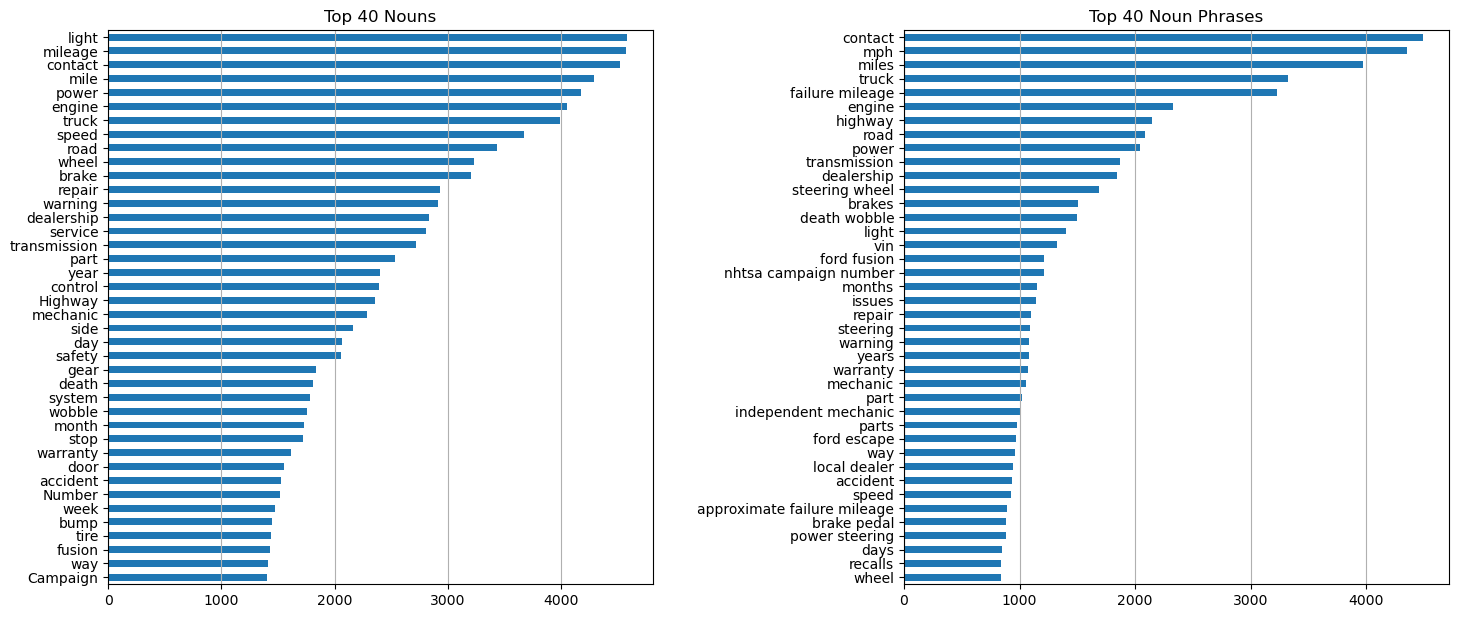

In [33]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,10))
figure.tight_layout(pad=15)
noun_row_df['Nouns'].value_counts().head(40).sort_values().plot(kind='barh', ax=ax1) 
ax1.title.set_text('Top 40 Nouns')
ax1.xaxis.grid(True)
noun_phrase_row_df['Noun Phrases'].value_counts().head(40).sort_values().plot(kind='barh', ax=ax2) 
ax2.title.set_text('Top 40 Noun Phrases')
ax2.xaxis.grid(True)

plt.show()

### Findings

Noun phrases yield more specific insights than nouns on their own. For example, parts appear in the list, such as _brake pedal_ and _steering wheel_. In the noun analysis, it is not clear what _wheel_ or _brake_ refers to. Also, _death wobble_ is extracted as a single phrase in the noun phrase analysis whereas it is split between _death_ and _wobble_ in the noun analysis.

<a id="correlate_n_nph"></a>
## Identify nouns and noun phrases that are _specific_ to a given model with Association Rule Mining

[Association Rule Mining](https://en.wikipedia.org/wiki/Association_rule_learning) is typically used for tasks such as market-basket analysis. In this notebook it can be used to identify the nouns that occur most frequently in relation to a particular car model. The idea is to create items like `(model, noun)` , and let the algorithm find rules that show that if a certain `noun` occurs, a particular `model` occurs often as well. This filters out nouns that occur frequently across many car models. 

In [34]:
# Install an Association Rule Mining algorithm that uses the "FPGrowth" approach
!pip install fpgrowth_py

In [35]:
import fpgrowth_py.fpgrowth as fpgrowth

### Run association rule mining on (model, noun) pairs

To get to the _specific_ nouns, the notebook limits the rule generation to:

- (model, noun) pairs that appear more than 100 times. This is done by setting the _minimum support_ for a rule in the `minSupRatio` attribute. This removes rules that contain very infrequent nouns that only occur in a small number of complaints.
- When a certain noun appears, you want the model to appear at least 25% of the time or more. This is done by setting the _minimum confidence_ for a rule in the `minConf` attribute. This removes rules that contain nouns that appear in many models at the same time. 

In [36]:
modelNounList = noun_row_df[['Model', 'Nouns']].values.tolist()
len(modelNounList)  # the total number of (model, noun) pairs

343573

In [37]:
min_support = 100 / len(modelNounList) 
min_support

0.0002910589598134894

Identify association rules across all models.

In [38]:
freqItemSet, rules = fpgrowth(modelNounList, minSupRatio=min_support, minConf=0.25)

Identify the rules for the `F-150` pickup truck. The number included in the rule is the _confidence_. For example, when the noun `speedometer` appears in 10 complaint descriptions, 6 of them will be about the `F-150`. Hence, the rule confidence is `0.60`.

In [39]:
for rule in rules:
    if 'F-150' in rule[1]:
        print(rule)

[{'speedometer'}, {'F-150'}, 0.6167400881057269]
[{'glass'}, {'F-150'}, 0.4448818897637795]
[{'master'}, {'F-150'}, 0.3795180722891566]
[{'frame'}, {'F-150'}, 0.40947075208913647]
[{'throttle'}, {'F-150'}, 0.3125]
[{'wrench'}, {'F-150'}, 0.38605898123324395]
[{'mode'}, {'F-150'}, 0.3026315789473684]
[{'trailer'}, {'F-150'}, 0.27684964200477324]
[{'shift'}, {'F-150'}, 0.31962616822429907]
[{'fluid'}, {'F-150'}, 0.2714285714285714]
[{'window'}, {'F-150'}, 0.3837579617834395]
[{'start'}, {'F-150'}, 0.2674050632911392]
[{'gear'}, {'F-150'}, 0.2904632152588556]
[{'truck'}, {'F-150'}, 0.32139278557114226]


### Show the nouns that are specific to a model

Collect the nouns and create a tree map to show the nouns, sized by the rule confidence.

In [40]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud

In [41]:
from wordcloud import WordCloud

# Collect the nouns found in the association rules for <model>. 
# Show the nouns in a word cloud, sized by the rule confidence.
def show_rules_for_model(rules, model):
    modelDict = {}
    for rule in rules:
        if model in rule[1]:
            noun=next(iter(rule[0]))
            if model.lower() not in noun: # we don't want to include the model name itself in the word cloud
                modelDict[noun] = int(rule[2]*1000)
    wc_a = WordCloud(width=700, height=200, background_color ='white',colormap='tab10', prefer_horizontal=0.9).generate_from_frequencies(modelDict)
    figure, ax1 = plt.subplots(ncols=1, figsize=(11,7))
    figure.tight_layout()
    ax1.imshow(wc_a, interpolation="bilinear")
    ax1.axis("off")
    ax1.title.set_text("Correlated terms for " + model)
    plt.show()


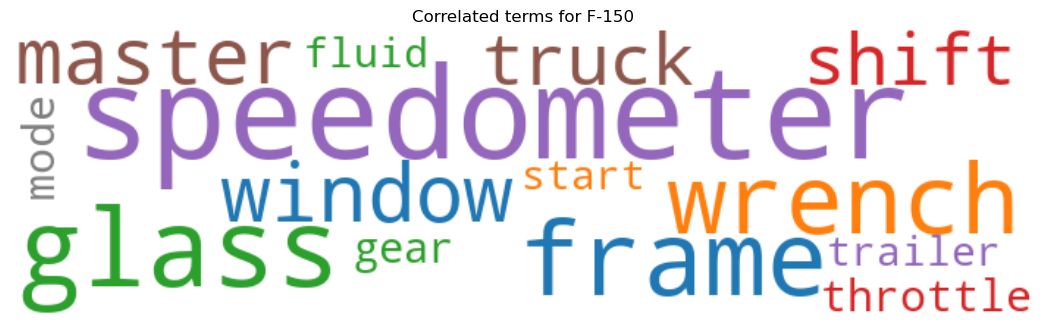

In [42]:
show_rules_for_model(rules, 'F-150')

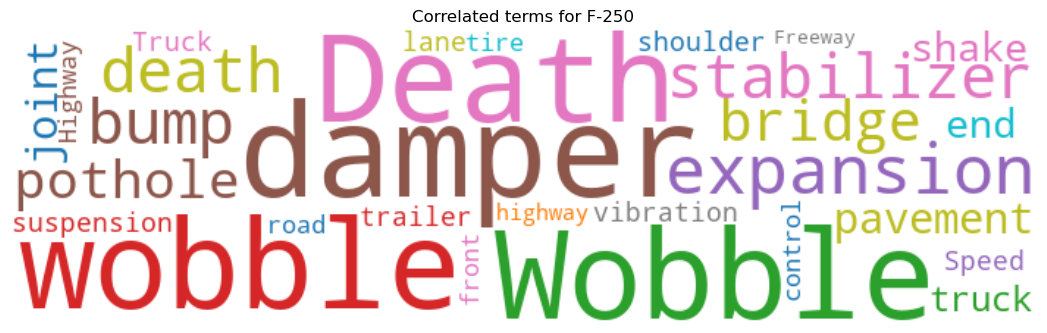

In [43]:
show_rules_for_model(rules, 'F-250')

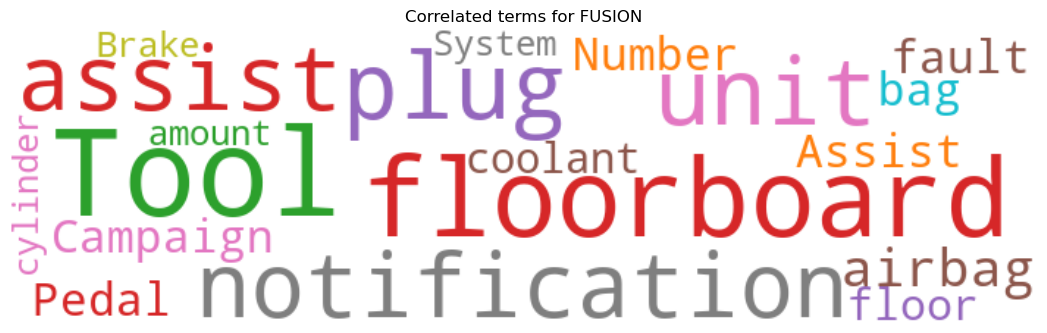

In [44]:
show_rules_for_model(rules, 'FUSION')

### Show the noun phrases that are specific to a model

Collect noun phrases and create a word cloud to show noun phrases.

In [45]:
modelNounPhraseList = noun_phrase_row_df[['Model', 'Noun Phrases']].values.tolist()
len(modelNounPhraseList)

341989

In [46]:
min_support_np = 100 / len(modelNounPhraseList) 
min_support_np

0.00029240706572433614

In [47]:
np_freqItemSet, np_rules = fpgrowth(modelNounPhraseList, minSupRatio=min_support_np, minConf=0.25)

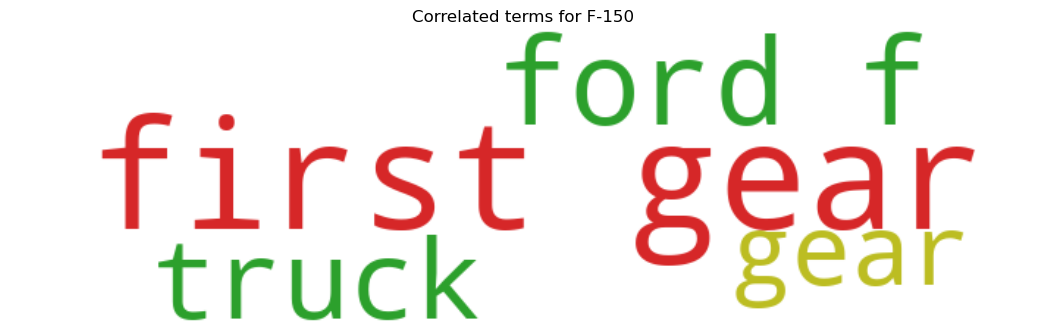

In [48]:
show_rules_for_model(np_rules, 'F-150')

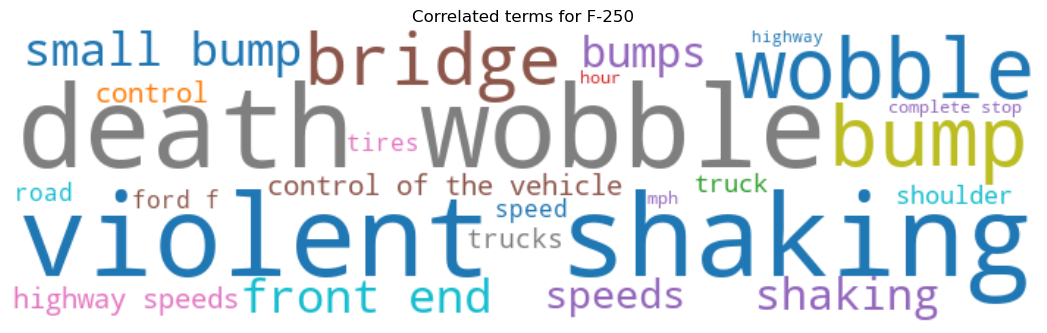

In [49]:
show_rules_for_model(np_rules, 'F-250')

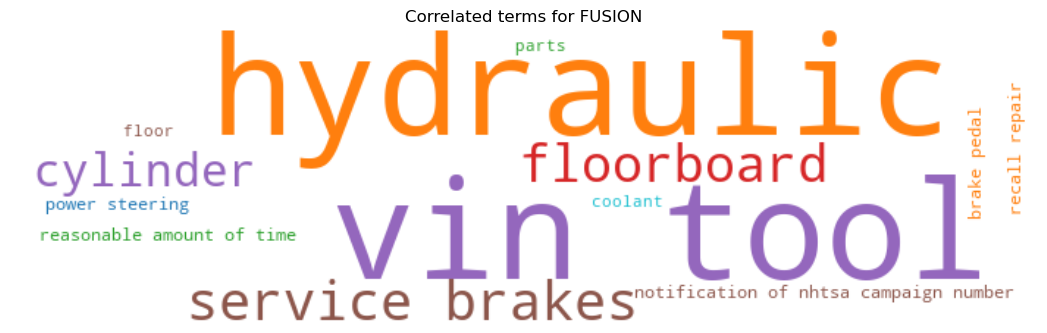

In [50]:
show_rules_for_model(np_rules, 'FUSION')

<a id="summary"></a>
## Summary

This notebook demonstrates how simple NLP techniques, such as extraction of nouns and noun phrases can yield significant insights: 
- The _Part_Of_Speech_ detection of the Watson NLP `Syntax` block is used to focus on specific word types (in this case, nouns). The _lemma_ detection ensures that all variants (such as _"wiper", "wipers",_ etc. ) are combined into a single entry. 
- The _Noun Phrase_ block of Watson NLP extracts additional terms, which provide more insigts as compared to single nouns (for example, _"steering wheel" vs. "wheel"). 
- _Association Rule Mining_  can be used to correlate text analysis results with structured data (in this case, the car model). In this case, it highlighted model-specific problems (such as the _"death wobble"_ reported for R-250 trucks)

## Authors

__Alexander Lang__ IBM, Germany

__Simone Zerfass__ IBM, Germany

# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.